In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
using BenchmarkTools;
using CUDA
using Base: @doc
using Revise
using Random: shuffle, randperm

push!(LOAD_PATH, "../../src");
using Pose2D: Pose
using Geometry: Segment
using MyUtils
using Raycaster
using SensorDistributions;

In [3]:
# display(@doc get_1d_mixture_components)
# display(@doc depthdist_2dp3)

In [4]:
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt: @f_str, format # Python-style f-strings
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using GenDistributionZoo: ProductDistribution

const diagnormal = broadcasted_normal

mvuniform = ProductDistribution(uniform);

## Load Environment

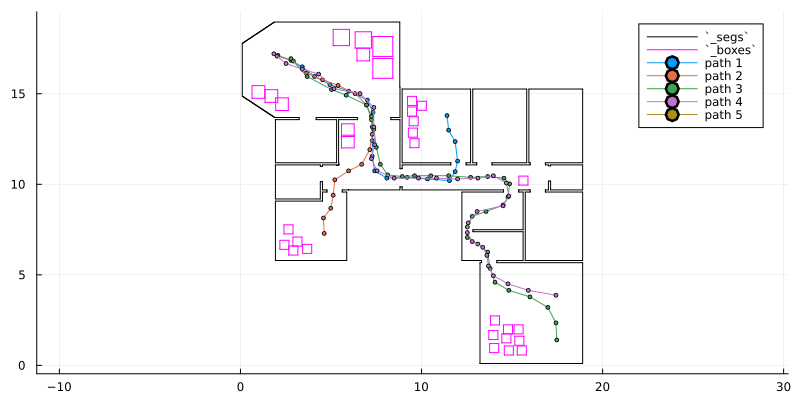

In [5]:
include("../../src/house_expo_utils.jl");

fname = "../data/task_inputs/test_env_1.json"
_segs, _boxes, _paths = load_env(fname)
_bb = bounding_box(_segs)

# ----------------
mypl = plot(size=(800, 400), aspect_ratio=:equal)
plot!(_segs, c=:black, label="`_segs`")
plot!(_boxes, c=:magenta, label="`_boxes`")
for (i,xs) in enumerate(_paths)
    plot!(xs, marker=:o, markersize=2, c=col[i], label="path $i")
end
mypl

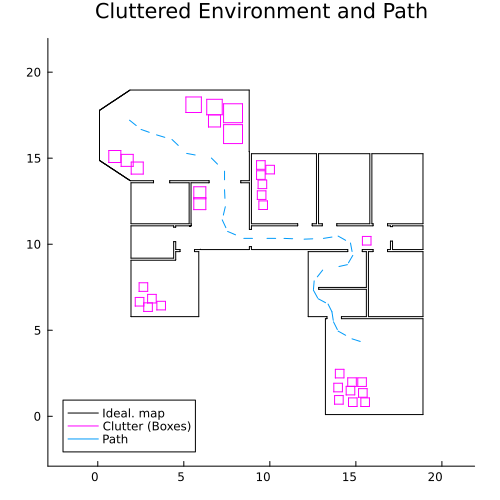

In [6]:
_ps, _us = unpack_path(_paths[4])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Cluttered Environment and Path", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(_ps, c=col[1], linewidth=1, label="Path")
mypl

In [7]:
#nbx
"""
    zs, _as, ys = create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    
Return depth measurements `zs` and the angles `_as` along which the measuremnts were taken, 
and their 2D point cloud version `ys` for a given set of poses `ps` and a map `segs` of line
segments.

Example:
```julia
    _obs_noise = 0.1
    _fov       = 2π
    _num_a     = 361
    _zs, _as, _ys   = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)
```
"""
function create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    segs = stack(Vector.(segs));
    ps   = stack(Vector.(ps));

    zs  = cast(ps, segs; fov=fov, num_a=num_a)
    zs += _obs_noise * randn(size(zs))
    zs  = unstack(zs);

    as  = [range(-fov/2, fov/2, _num_a)...];
    ys  = [polar_inv(z,as) for z in zs]
    return zs, as, ys
end

create_observations

In [8]:
#nbx
_obs_noise = 0.1
_fov       = 2π
_num_a     = 360

# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

# -------------
println("Created a few new variables:\n")
summarize_vars(:(_obs_noise, _fov, _as, _zs, _ys))
println("")

Created a few new variables:

_obs_noise Float64
_fov       Float64
_as        Vector{Float64}
_zs        Vector{Vector{Float64}}
_ys        Vector{Vector{Vector{Float64}}}



[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif")
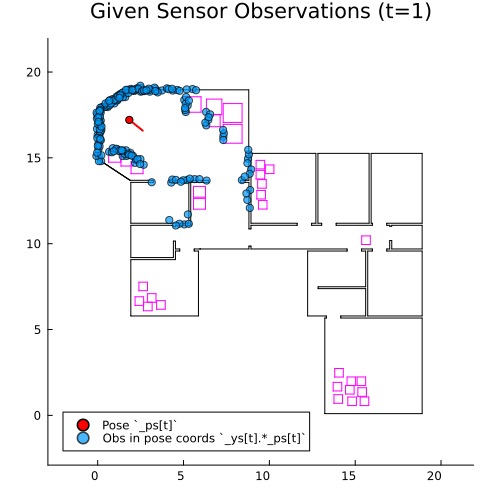

In [9]:
# -----------------------
ani = Animation()
for t=1:1:_T
    p = _ps[t]
    y = _ys[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Given Sensor Observations (t=$t)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!(_boxes, c=:magenta, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(shuffle(y[1:2:end]).*p, c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")
    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=4)

In [10]:
_T

29

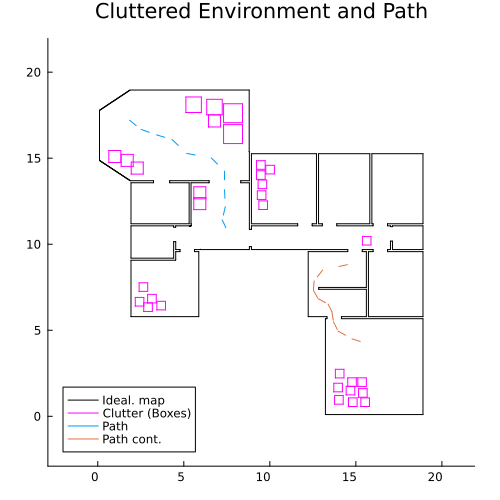

In [11]:
ts_1 = 1:10 
ts_2 = 20:_T
_zs_tp = [_zs[ts_1]; _zs[ts_2]]

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Cluttered Environment and Path", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(_ps[ts_1], c=col[1], linewidth=1, label="Path")
plot!(_ps[ts_2], c=col[2], linewidth=1, label="Path cont.")
mypl



(1, 360, 100, 100)
min = -941.1456284718366 max = -344.53750305253425
min = -2486.7918085188167 max = -827.0558927431349


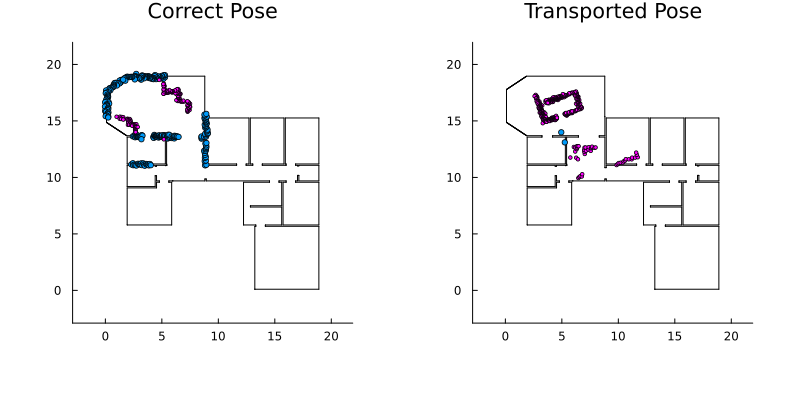

In [139]:
t1 = 4
t2 = 25

w       = 20
sig     = range(0.05, 2., 100)
outlier = range(0.01,1., 100)
zmax    = 10.


p = _ps[t1] + Control(diagnormal([0.0;0.0], [0.1;0.1]), normal(0, 0.01/180*π))

vs   = stack(Vector.([p]));
segs = stack(Vector.(_segs));

vs_ = DeviceArray(vs)
segs_ = DeviceArray(segs)

zs   = cast(vs_, segs_; fov=_fov, num_a=_num_a, zmax=zmax)
zs_ = DeviceArray(zs)
as_ = DeviceArray(_as);

ỹ, d̃ = get_1d_mixture_components(zs_, as_, w);

ỹ_ = DeviceArray(ỹ)
d̃_ = DeviceArray(d̃)
sig_     = DeviceArray(sig)
outlier_ = DeviceArray(outlier)

zs1_ = DeviceArray(_zs[t1])
zs2_ = DeviceArray(_zs[t2])

log_p1, ptw1, outl1 = depthdist_logpdf(zs1_, ỹ_, d̃_, sig_, outlier_, zmax; 
                                    return_pointwise=true, return_outliermap=true);

log_p2, ptw2, outl2 = depthdist_logpdf(zs2_, ỹ_, d̃_, sig_, outlier_, zmax; 
                                    return_pointwise=true, return_outliermap=true);

log_p1 = Array(log_p1)
log_p2 = Array(log_p2);

println(size(outl1))

println("min = $(minimum(log_p1)) max = $(maximum(log_p1))")
println("min = $(minimum(log_p2)) max = $(maximum(log_p2))")

i1 = argmax(log_p1[1,:,:])
i2 = argmax(log_p2[1,:,:])


# -----------------------
plot_1 = plot(size=(500,500), aspect_ratio=:equal, title="Correct Pose", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
scatter!(_ys[t1][.!outl1[1,:,i1]] .* p, c=col[1], linewidth=1, markersize=3, label="Path")
scatter!(_ys[t1][  outl1[1,:, i1]] .* p, c=:magenta, linewidth=1, markersize=2, label="Path")

plot_2 = plot(size=(500,500), aspect_ratio=:equal, title="Transported Pose", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
scatter!(_ys[t2][.!outl2[1,:,i2]] .* p, c=col[1], linewidth=1, markersize=3, label="Path")
scatter!(_ys[t2][  outl2[1,:,i2]] .* p, c=:magenta, linewidth=1, markersize=2, label="Path")

plot(plot_1, plot_2, layout=(1,2),  size=(800,400), legend=false,
    right_margin  = 10Plots.mm,
    left_margin   = 10Plots.mm,
    bottom_margin = 10Plots.mm
)

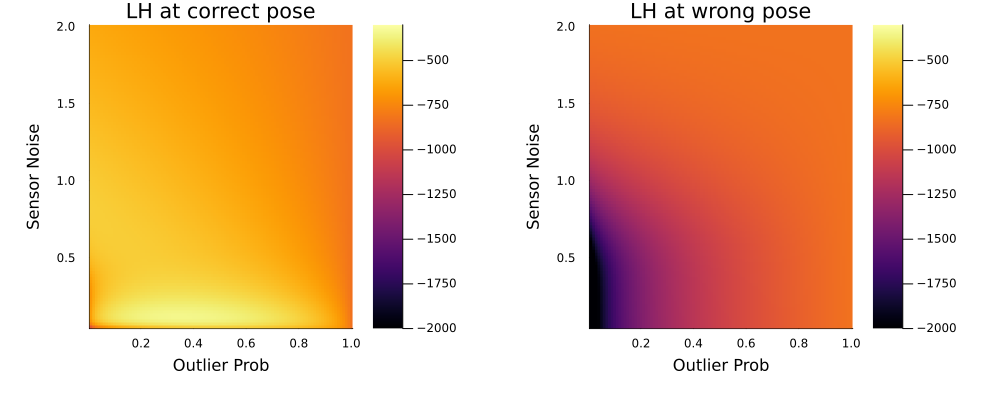

In [142]:
plot_1 = plot(size=(400,400), title = "LH at correct pose",
    grid=false, xlabel="Outlier Prob", ylabel="Sensor Noise", right_margin = 10Plots.mm
)
heatmap!(outlier, sig, log_p1[1,:,:], clim=(-2000, -300))

plot_2 = plot(size=(400,400), title = "LH at wrong pose",
    grid=false, xlabel="Outlier Prob", ylabel="Sensor Noise", right_margin = 10Plots.mm
)
heatmap!(outlier, sig, log_p2[1,:,:], clim=(-2000, -300))

plot(plot_1, plot_2, layout=(1,2),  size=(1000,400), legend=false,
    right_margin  = 10Plots.mm,
    left_margin   = 10Plots.mm,
    bottom_margin = 10Plots.mm
)

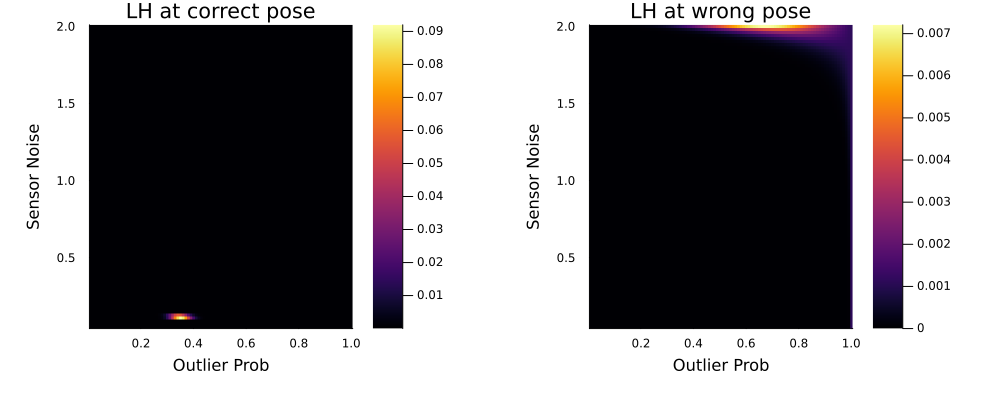

In [143]:
prob1 = exp.(log_p1[1,:,:] .- logsumexp(log_p1[1,:,:]))
prob2 = exp.(log_p2[1,:,:] .- logsumexp(log_p2[1,:,:]))


plot_1 = plot(size=(400,400), title = "LH at correct pose",
    grid=false, xlabel="Outlier Prob", ylabel="Sensor Noise", right_margin = 10Plots.mm
)
heatmap!(outlier, sig, prob1)

plot_2 = plot(size=(400,400), title = "LH at wrong pose",
    grid=false, xlabel="Outlier Prob", ylabel="Sensor Noise", right_margin = 10Plots.mm
)
heatmap!(outlier, sig, prob2)

plot(plot_1, plot_2, layout=(1,2),  size=(1000,400), legend=false,
    right_margin  = 10Plots.mm,
    left_margin   = 10Plots.mm,
    bottom_margin = 10Plots.mm
)